# __HY573 - Assignment 1__

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## <u>__Exercise 2: Interpretation & Reduction Using SVD & PCA__</u>

### __2.2 Data Exploration__

#### (a)

In [5]:
mov = pd.read_csv('data/ratings.csv')
display(mov.head())

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
n_users = mov.userId.unique().shape[0]
n_movies = mov.movieId.unique().shape[0]
n_ratings = len(mov)
print(f'Number of users = {n_users} | Number of movies = {n_movies}')
print(f'Total number of ratings = {n_ratings}')

Number of users = 610 | Number of movies = 9724
Total number of ratings = 100836


#### (b)

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

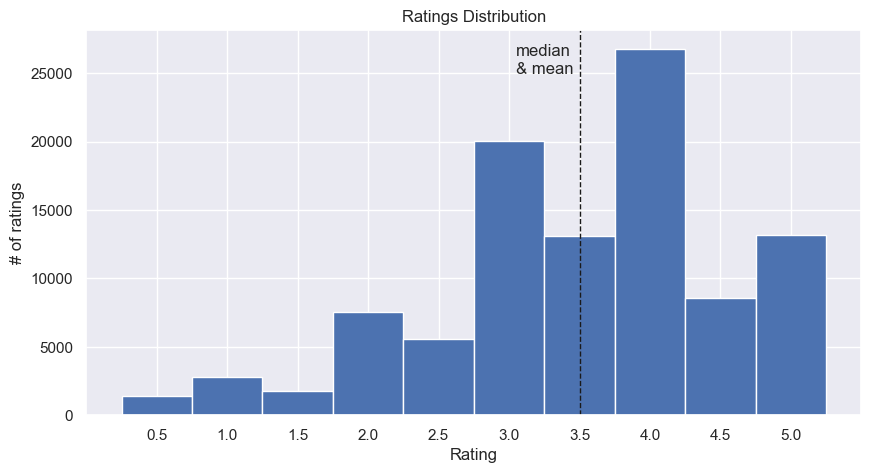

In [7]:
display(mov['rating'].describe())

edges = np.arange(0.25, 5.75, 0.5)
mov['rating'].plot(kind='hist', bins=edges, figsize=(10,5))
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('# of ratings')
plt.xticks(np.sort(mov.rating.unique()))
median = mov.rating.median()
plt.axvline(median, color='k', linestyle='dashed', linewidth=1)
plt.annotate('median\n& mean', xy=(median-0.45, 25000))
plt.show()

We can see that the majority of ratings is above average, with both the mean and the median being 3.5 and even the 25th percentile being above average (3), so we can say that the users are in general generous with their ratings.

#### (c-d)

In [8]:
mat = mov.pivot(index='userId', columns='movieId', values='rating')
mat

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see from the beginning that the user-rating matrix appears to be quite sparse (i.e. many missing values). This is expected, since the number of movies is much larger than the number of users. We can see this in more detail using the heatmap below.

#### (e)

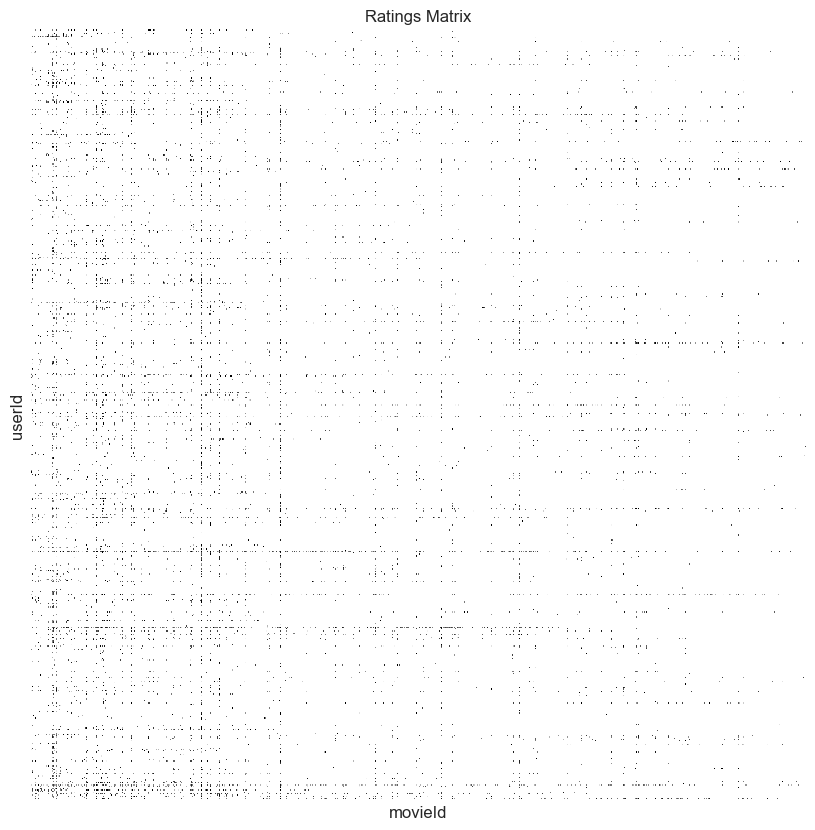

In [9]:
# replace missing values with 0 for now
mat[mat.isna()] = 0

plt.figure(figsize=(10, 10))
sns.heatmap(np.abs(mat), cbar=False, cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('Ratings Matrix')
plt.show()

We can see in the heatmap above (white is where the value is missing and black is where there is a value) that the matrix is indeed very sparse. Especially towards the right side, the movies have very few ratings, and in general, it is mostly white. The movies towards the left are presumable more popular, since the data there is more dense, but there still isn't a big difference.

### __2.3 Data interpretation using SVD__

#### (a)

SVD for a matrix $A$ of size $m \times n$ and rank $r$ can be computed as follows:

1. If $m \leq n$, then $\lambda_i$ and $\vec{u_i}$ are the result of the eigendecomposition of $AA^T$ (eigenvalues and eigenvectors respectively). Then we have $U$, $Σ$ and $V^T$ as follows:
     - $U = \begin{bmatrix} \mathbf{u_1} & \mathbf{u_2} & \dots & \mathbf{u_r} \end{bmatrix}$
     - $Σ = \begin{bmatrix} \sqrt{λ_1} & 0 & \dots & 0 \\ 0 & \sqrt{λ_2} & \dots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & \sqrt{λ_r}\end{bmatrix}$
     - $V^T = Σ^{-1}U^TA$

2. If $m > n$, then $λ_i$ and $\vec{ν_i}$ are the result of the eigendecomposition of $A^TA$. Then:
     - $V^T = \begin{bmatrix} \mathbf{ν_1^T} \\ \mathbf{ν_2^T} \\ \vdots \\ \mathbf{ν_r^T} \end{bmatrix}$
     - $Σ = \begin{bmatrix} \sqrt{λ_1} & 0 & \dots & 0 \\ 0 & \sqrt{λ_2} & \dots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & \sqrt{λ_r}\end{bmatrix}$
     - $U = (Σ^{-1}VA)^T$ <br>

     This is equivalent to computing $U_1$, $Σ_1$ and $V^T_1$ for $A^T$ using the case (1) and then setting $U := V_1$ and $V^T := U_1^T$ (this is how I implemented it here).

<br>

Note: this function computes
- only the diagonal elements of $Σ$, $\sqrt{λ_i}$
- the reduced form of $U$, $Σ$, $V^T$

equivalent to 
```scipy.linalg.svd(A, full_matrices=False)```

In [10]:
def custom_svd(A):
	M, N = A.shape

	if M <= N:
		s, U = np.linalg.eigh(A @ A.T)
		s = np.sqrt(s)
		Vt = np.linalg.inv(np.diag(s)) @ np.dot(U.T, A)

		idx = np.argsort(s)[::-1]
		U = U[:, idx]
		s = s[idx]
		Vt = Vt[idx, :]

	else:
		V, s, U = custom_svd(A.T)
		U = U.T
		Vt = V.T

	return U, s, Vt

In [11]:
U, S, Vt = custom_svd(mat)

Let's confirm that the above implementation works as expected. We'll use RMSE to compare the original matrix $A$ with the reconstructed one $U Σ V^T$:

In [12]:
def rmse(A, B):
	return np.sqrt(np.mean(np.square(A - B)))

print('RMSE between original and reconstructed matrix:')
reconstr = U @ np.diag(S) @ Vt
print(f'{rmse(mat, reconstr):.20f}')

RMSE between original and reconstructed matrix:
0.00000000000000092639


#### (b)

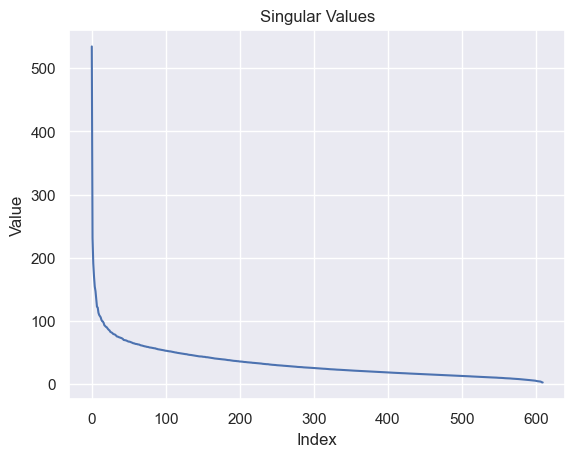

In [13]:
plt.plot(S)
plt.title('Singular Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.xticks(np.arange(0, len(S), 100))
plt.show()

The singular values represent the amount of information that is contained in each of the singular vectors. Here they are ordered in descending order, the same as their respective singular vectors, so the first vectors contains the most information about our matrix and then the information that is contained in each eigenvector after that is lower, according to the respective eigenvalue. We will see later in PCA how this is used to reduce the dimensionality of the data.

#### (c)

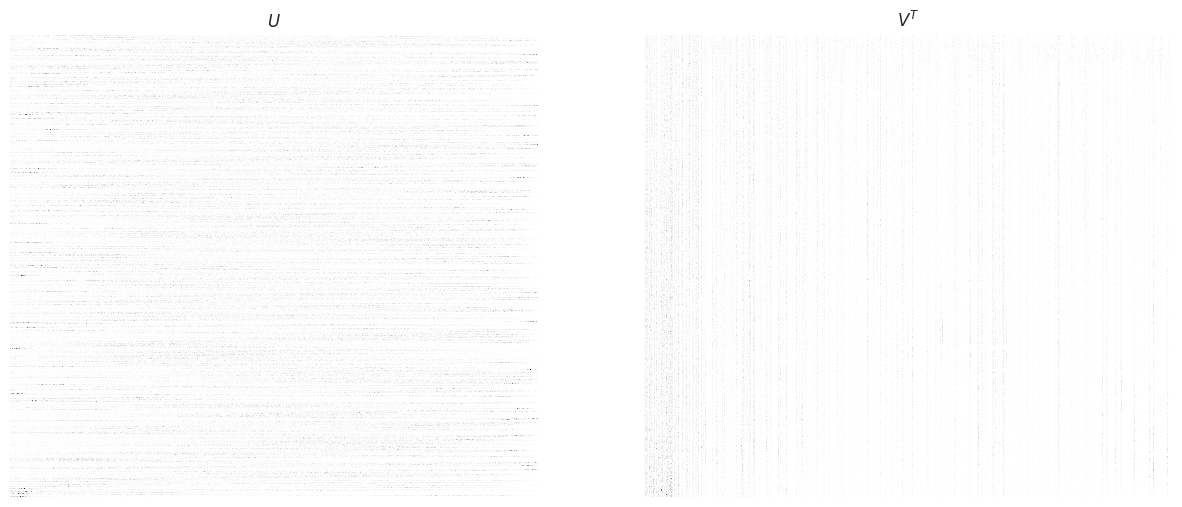

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(np.abs(U), cbar=False, ax=axs[0], cmap='Greys')
axs[0].set_title('$U$')
axs[0].set_xticks([])
axs[0].set_yticks([])

sns.heatmap(np.abs(Vt), cbar=False, ax=axs[1], cmap='Greys')
axs[1].set_title('$V^T$')
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.show()

The visualisations above are the heatmap of U (left singular vectors) and V (right singular vectors) respectively. One would hope that this would be a good way to visualise the data, however what we're seeing here is not very clear. Especially in U there doesn't appear to be any structure, while V appears to be more dense towards its left third, with a few dense vertical "strips" in the middle and right thirds. These could signify related movies in some way (e.g., same genre), however I don't think we can make any definite conclusions from this.

#### (d)
SVD cannot be computed when there are missing values in the matrix. The default is to change those to 0 and proceed with the SVD. Other approaches can well be used, such as imputing the missing values with the mean of the column or the row, or even the mean of the whole matrix, however they should be used with caution, since they can introduce bias.

### __2.4  Reducing Complexity with PCA__

#### (a)

PCA for a matrix $A$ of size $m \times n$ and rank $r$ can be implemented using SVD as follows:

$U$, $Σ$, $V^T$ is the result of SVD for matrix $A_0$, the zero-centered matrix $A$. We order the singular values in $Σ$ in descending order and the rows of $V^T$ in the same order.

Then the first $k \leq r$ principal components of $A$ are the first $k$ rows of $V^T$ and the squares of the first $k$ singular values is the percentage of the variance in $A$ that is explained by the corresponding $i$-th principal component.

In [15]:
def custom_pca(A, k=None):
	_, S, Vt = custom_svd(A - A.mean(axis=0))
	S = np.power(S, 2)

	if k is None:
		k = np.linalg.matrix_rank(A)

	idx = np.argsort(S)[::-1][:k]
	components = Vt[idx, :]
	explained_variance = S[idx] / np.sum(S)

	return components, explained_variance

In [16]:
pcs, var = custom_pca(mat)

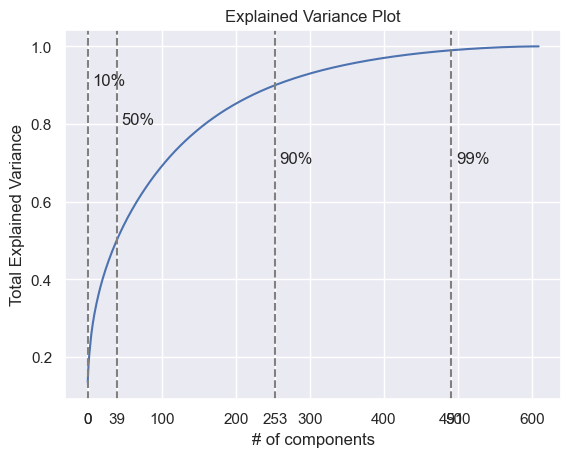

In [17]:
# plt.plot(var)
plt.plot(np.cumsum(var))
plt.title('Explained Variance Plot')
plt.xlabel('# of components')
plt.ylabel('Total Explained Variance')
top10 = np.argwhere(np.cumsum(var)/np.sum(var) >= 0.1)[0][0]
top50 = np.argwhere(np.cumsum(var)/np.sum(var) >= 0.5)[0][0]
top90 = np.argwhere(np.cumsum(var)/np.sum(var) >= 0.9)[0][0]
top99 = np.argwhere(np.cumsum(var)/np.sum(var) >= 0.99)[0][0]
plt.axvline(top10, c='grey', ls='--')
plt.axvline(top50, c='grey', ls='--')
plt.axvline(top90, c='grey', ls='--')
plt.axvline(top99, c='grey', ls='--')
plt.annotate('10%', (top10+0.01*var.shape[0], 0.9))
plt.annotate('50%', (top50+0.01*var.shape[0], 0.8))
plt.annotate('90%', (top90+0.01*var.shape[0], 0.7))
plt.annotate('99%', (top99+0.01*var.shape[0], 0.7))
plt.xticks(np.concatenate((np.arange(0, len(var), 100), np.array([top99, top90, top50, top10]))))
plt.show()

We can see in the plot above the explained variance ratio for each of the principal components, which is related to the plot of the singular values of SVD that we saw earlier. In fact, when SVD is used to compute PCA, like I did here, the explained variance ratio is equal to the square of the singular values (and the principal components are the left singular vectors in U). We can see that the curve has a steep slope at the beginning and then eventually flattens, which means that the first proncipal components explain the most relative variance in the data, and the next ones explain less and less variance. This is in comparison to the "importance of information contained" that was explained for the SVD singular values.

#### (b)

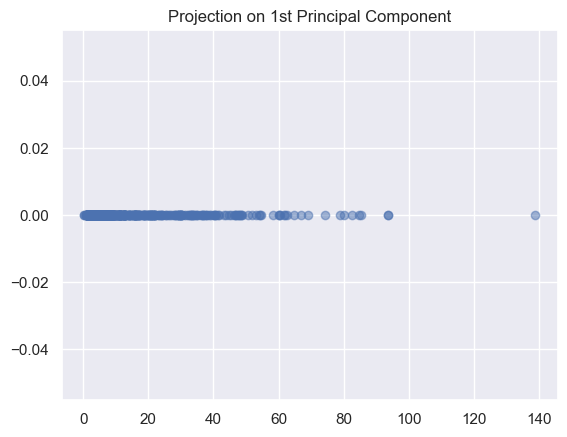

In [18]:
proj1 = mat @ pcs[0].T
plt.scatter(proj1, np.zeros_like(proj1), alpha=0.5)
plt.title('Projection on 1st Principal Component')
plt.show()

We see that, of course, the projection on the first principal component lies on a straight line. We can see that most users lie towards the right side, while there are some who exist towards the center and a sole one who is tor=wards the left. While the meaning of the principal components is not straightforward, we can say that most users appear to be on a spectrum based on their overall ratings, which is dense towards the left side, but then there are some users with differences in their ratings (those in the center), while there is one user who is very different from the rest (the one on the right). In this sense, we can se how the variance in the data is explained by the first principal component.

#### (c)

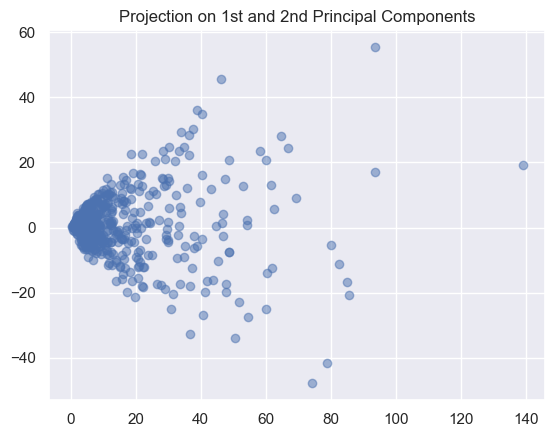

In [19]:
proj2 = mat @ pcs[1].T
plt.scatter(proj1, proj2, alpha=0.5)
plt.title('Projection on 1st and 2nd Principal Components')
plt.show()

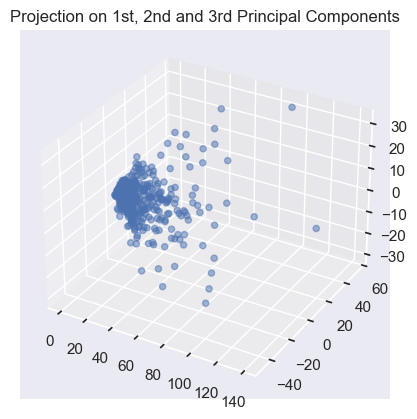

In [20]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
proj3 = mat @ pcs[2].T
ax.scatter(proj1, proj2, proj3, alpha=0.5)
ax.set_title('Projection on 1st, 2nd and 3rd Principal Components')
plt.show()

When we move from only the 1st PC to the 2 and then 3 forst PCs, we can see of course that the variance in the respective plots is greater. However, it is evident that the added variance is not as much as the variance that existed in the first place. For example, in the 2D graph, where it is easier to see, there is no outlier that is greater than the one that already existed in the 1st projection (the user on the far left). However in these plots it is easier so further see the differences between the users that are in the center of the 1st projection, since they are more spread out in the 2nd and 3rd projections, while the big cluster on the left remains.

## <u>__Exercise 3: User Similarity via PCA Projections__</u>

### __3A: Train-Vaidation Split__

In [21]:
n = int(mat.shape[0]*0.7)
idx = np.arange(mat.shape[0])
idx.sort()

train = np.random.choice(idx, n, replace=False)
val = mat.iloc[np.setdiff1d(idx, train)]
train = mat.iloc[train, :].sort_index()

### __3B: PCA on Training Data__

In [22]:
pcs, var = custom_pca(train)

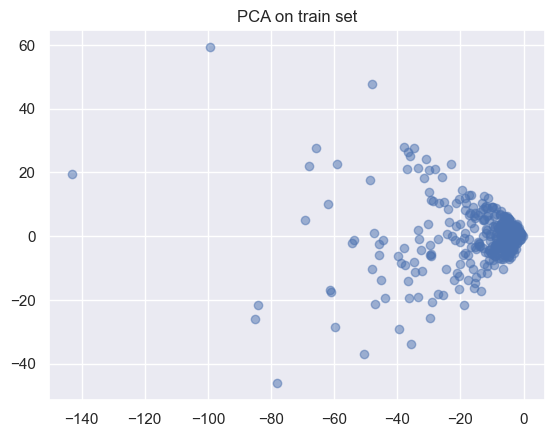

In [23]:
t_proj1 = train @ pcs[0].T
t_proj2 = train @ pcs[1].T

plt.scatter(t_proj1, t_proj2, alpha=0.5)
plt.title('PCA on train set')
plt.show()

We can see that the main cluster on the left remains, however due to the stochasticity of the split, the result is a bit different, in the way that it is more spread out and there are more apparent outliers.

### __3C. Projecting Validation Users__

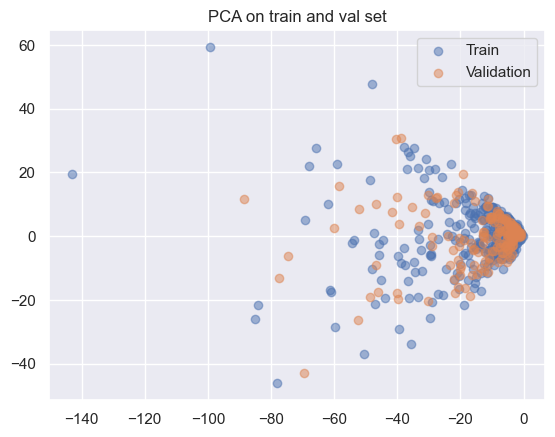

In [24]:
v_proj1 = val @ pcs[0].T
v_proj2 = val @ pcs[1].T

plt.scatter(t_proj1, t_proj2, alpha=0.5)
plt.scatter(v_proj1, v_proj2, alpha=0.5)
plt.legend(['Train', 'Validation'])
plt.title('PCA on train and val set')
plt.show()

We can see in the plot, where the projections of the train and validation data exist together, that their distributions are similar, with a couple of extremes in each, like we would expect from random splits, so we can proceed with the next step.

### __3D. Finding Nearest Neighbors in Low-Dimensional Space__

We'll use the projection of the train and validatin data on the first 3 components, in order to find the 5 nearest neighbors of each validation user in the training data.

The distance I'll use is the cosine distance, because I think that the direction will be more important than the straight distance for judging similarity in this latent space.

In [25]:
def get_df(u_idx, n_idxs):
	user = val.iloc[[u_idx]]
	neighbors = train.iloc[n_idxs]

	df = pd.concat((user, neighbors))
	df[df == 0] = pd.NA
	df.dropna(axis=1, how='all', inplace=True, subset=user.index)
	# df.dropna(axis=1, thresh=2, inplace=True, subset=neighbors.index)
	df.fillna(0, inplace=True)

	df['# common'] = df.apply(lambda x: df.shape[1] - np.sum(x == 0), axis=1)
	# df.sort_values(by='common', inplace=True)
	cols = df.columns.to_list()
	df = df[cols[-1:] + cols[:-1]]

	return df

def plot_neighbors(u_idx, n_idxs, ax=None):
	n = len(n_idxs)
	df = get_df(u_idx, n_idxs)

	if ax is None:
		fig, ax = plt.subplots()
	sns.heatmap(df.iloc[:, 1:], ax=ax)
	ax.axhline(1, c='w', ls='--')
	ax.set_xlabel('Movie')
	ax.set_ylabel('User')
	ax.set_xticks([])
	ylabels = ['val'] + [f'n. {i+1}' for i in range(n)]
	ax.set_yticks(np.arange(0.5, n+1.5), ylabels)
	ax.set_title('Validation User and their Nearest Neighbors')

	return df

Visualising the results for the 1st validation user:

movieId,# common,1,3,6,47,50,70,101,110,151,...,3671,3702,3703,3729,3740,3744,3793,3809,4006,5060
userId,,,,,,,,,,,,,,,,,,,,,
1,232,4.0,4.0,4.0,5.0,5.0,3.0,5.0,4.0,5.0,...,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0
160,98,4.0,0.0,2.0,5.0,4.0,0.0,0.0,4.0,0.0,...,0.0,1.5,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
91,117,4.0,3.0,5.0,4.5,4.5,0.0,0.0,4.0,3.0,...,4.5,0.0,5.0,0.0,5.0,0.0,4.0,4.0,0.0,2.0
452,72,0.0,0.0,0.0,5.0,0.0,4.0,0.0,5.0,0.0,...,0.0,4.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
255,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Average # of common movies rated: 60.40


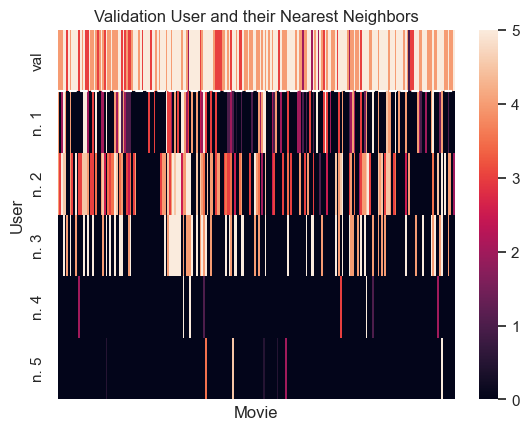

In [26]:
t_proj3 = train @ pcs[:3].T
v_proj3 = val @ pcs[:3].T

dists_p = scipy.spatial.distance.cdist(v_proj3, t_proj3, metric='cosine')
dists_p = dists_p / np.sum(dists_p)
idx_p = np.argsort(dists_p, axis=1)

df = plot_neighbors(0, idx_p[0, :5])

display(df)
print(f'Average # of common movies rated: {df.iloc[1:, 0].mean():.2f}')

In this example, we can see that the 5 nearest neighbors have a few common movies with the validation user, and they are quite similar but not very close. Because it will be hard to examine plots for many users and judge based on both number of common movies rated as well as how close these ratings are, we'll next use a metric that combines both of these, as a way to judge our results.

Firstly, we can see the average number of common movies rated between all validation users and their 5 nearest neighbors:

In [27]:
def common(a, b):
	a_nz = np.nonzero(a)[0]
	return a_nz.shape[0] - np.sum(b[a_nz] == 0)

avg = 0
for i in range(val.shape[0]):
	for j in range(5):
		avg += common(val.iloc[i].values, train.iloc[idx_p[i, j]].values)
avg /= val.shape[0]*5

print(f'Average # of common movies rated: {avg:.2f}')

Average # of common movies rated: 31.78


This number may seem low compared to the total number of movies that exist, however we should keep in mind that the number of movies that each user has rated is quite low, so it is a modest number.

Next, I'll use a custom metric that also takes into account how close the ratings are between the validation user and the 5 nearest neighbors for their common movies. The metric is the following:

For every user x and neighbor n pair, it calculates, only taking into account the indices where x has a (nonzero) rating (it is not symmetric), the sum of:
1. the mean difference between the ratings of x and n: $\frac{1}{|I_x|} \sum_{i \in I_x} |x_i - n_i|$
2. the mean number of movies where x has rated and hasn't, divided by 2, in order to also punish a bit more for every movie that x has rated but n hasn't: $\frac{1}{2|I_x|} \sum_{i \in I_x} (n_i == 0)$

so the final metric is:
$\,\, \frac{1}{|I_x|} \sum_{i \in I_x} |x_i - n_i| \,\,\, + \,\,\, \frac{1}{2|I_x|} \sum_{i \in I_x} (n_i == 0)$

where $I_x$ is the set of indices where x has a (nonzero) rating.

In [28]:
def custom_diff(a, b):
	a_nz = np.nonzero(a)
	return np.mean(np.abs(a[a_nz] - b[a_nz])) + np.mean(b[a_nz] == 0)/2

dists = scipy.spatial.distance.cdist(val, train, metric=custom_diff)

diff = 0
for i in range(val.shape[0]):
	for j in range(5):
		diff += dists[i, idx_p[i, j]]
diff /= val.shape[0]*5

print(f'Average difference for user 0 and his 5 nearest neighbors: {diff:.2f}')

Average difference for user 0 and his 5 nearest neighbors: 3.35


While this number doesn't make much sense in isolation, I'll use this metric next to improve the results. Specifically, if we recall from the explained varaince plot earlier, the first 3 PCs account only for a small fraction (~20%) of the total variance in the data, I'll try to find the best number of PCs to use for the projection, as well as the best number of neighbors to use for the prediction, in order to minimise this metric. While it will be hard to visualise individual results, because of their number, I think that this metric will be a good way to judge the results.

We're instructed to use the first 3 principal components, and first 5 neighbors, but since we already did that, I'll now use any possible values for both.

For the number of components to use, generally we know that the more we use the better, until a point where overfitting might occurs and the error could start increasing again. I'll use some arbitrary values in the range that we're working with [1, 427], specifically: {1, 2, 3, 5, 10, 30, 50, 100, 200, 300, 400}.

In [29]:
train_projs = {}
val_projs = {}

N_pcs = [1, 2, 3, 5, 10, 30, 50, 100, 200, 300, 400]

for k in N_pcs:
    t_proj = train @ pcs[:k].T
    v_proj = val @ pcs[:k].T

    train_projs[k] = t_proj
    val_projs[k] = v_proj

For the number of neighbors $k$, I'll start with all values in the range [1, 427] and then I'll narrow it down as needed.

In order to find the best hyperparameters, we need to compute some kind of error. Here,  I'll use the custom metric that I mentioned before. The total loss is the mean of this metric for all validation users, for each $k$, for a given number of principal components.

In [30]:
best_k = {}
losses = {}

def plot_loss(k, n_pcs, errors, min_error, metrics, ax=None):
	if ax is None:
		fig, ax = plt.subplots()
	ax.plot(np.arange(1, k+1), errors)

	m = list(metrics)
	for i in range(2):
		try:
			m[i] = m[i].__name__
		except AttributeError:
			pass

	ax.set_title(f'Mean Error ({n_pcs} PCs, {m[0]}, {m[1]})')
	ax.set_xlabel('k (# of neighbors)')
	ax.set_ylabel('Error')
	ax.axvline(min_error+1, c='black', ls='--')
	ax.annotate(f'min error ($k={min_error+1}$)', (min_error+1, errors.mean()))

def loss(k=5, n_pcs=5, metrics=('cosine', custom_diff), plot=False, save=False, ax=None):
	if save:
		if n_pcs in losses.keys():
			errors = losses[n_pcs]
			argmin = best_k[n_pcs]
			if plot:
				plot_loss(k, n_pcs, errors, argmin, metrics, ax)
			return errors, argmin

	if n_pcs not in train_projs.keys():
		train_projs[n_pcs] = train @ pcs[:n_pcs].T
		val_projs[n_pcs] = val @ pcs[:n_pcs].T

	# distances on projected space (cosine distance by default)
	dists_p = scipy.spatial.distance.cdist(val_projs[n_pcs], train_projs[n_pcs], metric=metrics[0])
	idx_p = np.argsort(dists_p, axis=1)

	# distances on original space (using custom metric I mentioned by default)
	dists = scipy.spatial.distance.cdist(val, train, metric=metrics[1])

	def error(k):
		E = 0
		for i in range(val.shape[0]):
			for j in range(k):
				E += dists[i, idx_p[i, j]]

		E /= val.shape[0]*k
		return E

	# error for each k
	ks = np.arange(1, k+1)
	errors = np.array([error(k) for k in ks])
	min_error = errors.argmin()

	if plot:
		plot_loss(k, n_pcs, errors, min_error, metrics, ax)
		# plt.show()

	if save:
		losses[n_pcs] = errors
		best_k[n_pcs] = min_error

	return errors, min_error

Let's first manually compare the loss for a couple of different number of PCs, and for all possible values of $k$, in order to get a sense of what is happening between those:

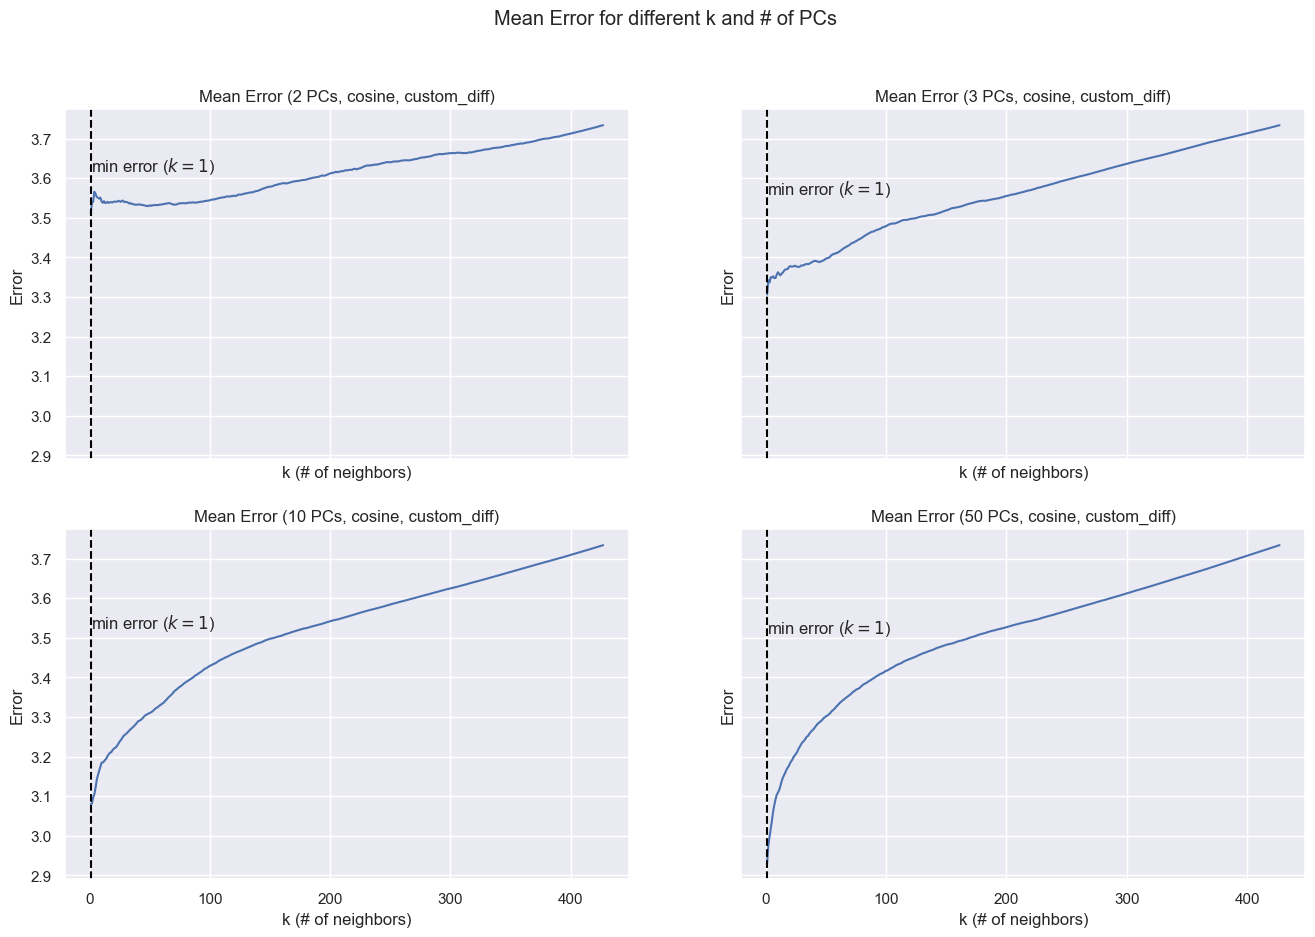

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axs = axs.flatten()
fig.suptitle('Mean Error for different k and # of PCs')

for i, n_pcs in enumerate([2, 3, 10, 50]):
    loss(k=427, n_pcs=n_pcs, plot=True, save=True, ax=axs[i]);

We can see here that as the number of principal components used increases, the minimum error decreases, while at the same time the $k$ for which this error is minimum iis in the low digits in the beginning, and then becomes 1.

What this means is that:
1. The more principal components we use, the lower the error, however there might be a point later where error starts increasing again.
2. When more principal components are used, the number of neighbors that are needed to make a good prediction decreases, and eventually 1 is enough. This could be because of the nature of the dataset, since it is very sparse, even if we reduce the dimensionality to find the neighbors, our 'ground truth' evaluation is based on distance in the original space, where it is difficult to find many close neighbors.

Next, we can see the loss for all possible values of $k$, for all values of the number of principal components as mentioned before: {1, 2, 3, 5, 10, 30, 50, 100, 200, 300, 400}.

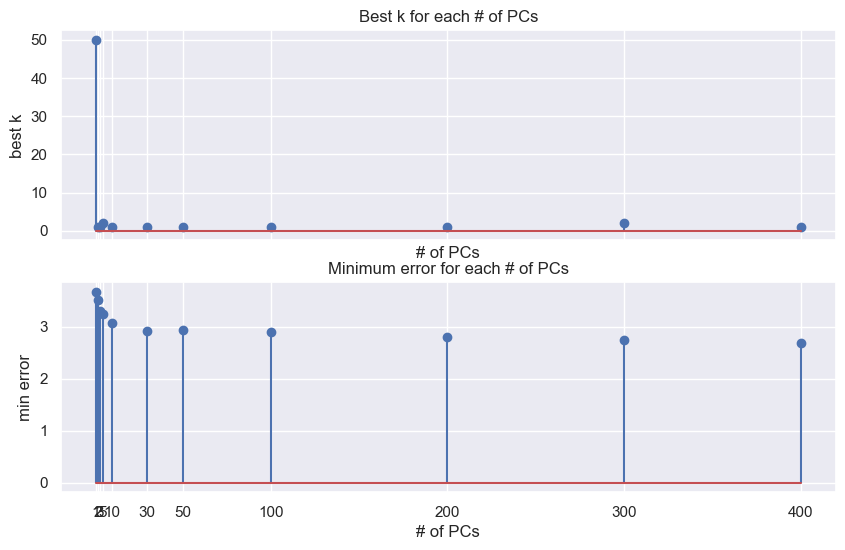

In [32]:
for n_pcs in N_pcs:
	loss(k=427, n_pcs=n_pcs, plot=False, save=True);

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

best_ks = dict(sorted(best_k.items()))
best_ks

axs[0].stem(np.array(list(best_ks.keys())), np.array(list(best_ks.values())) + 1)
axs[0].set_title('Best k for each # of PCs')
axs[0].set_xlabel('# of PCs')
axs[0].set_ylabel('best k')
axs[0].set_xticks(N_pcs)

min_errs = np.empty(len(N_pcs))
for i, n_pcs in enumerate(N_pcs):
    min_errs[i] = losses[n_pcs][best_k[n_pcs]]

axs[1].stem(N_pcs, min_errs)
axs[1].set_title('Minimum error for each # of PCs')
axs[1].set_xlabel('# of PCs')
axs[1].set_ylabel('min error')
axs[1].set_xticks(N_pcs)
plt.show()

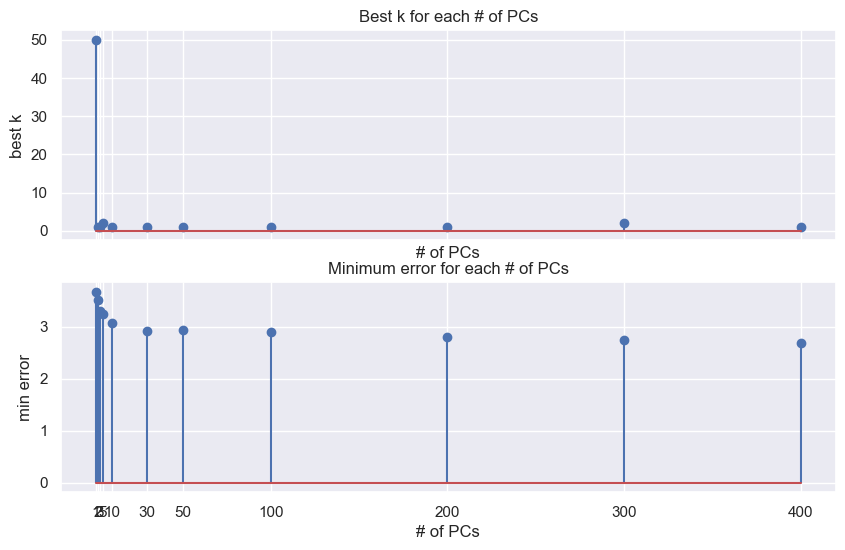

In [33]:
for n_pcs in N_pcs:
	loss(k=427, n_pcs=n_pcs, plot=False, save=True);

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

best_ks = dict(sorted(best_k.items()))
best_ks

axs[0].stem(np.array(list(best_ks.keys())), np.array(list(best_ks.values())) + 1)
axs[0].set_title('Best k for each # of PCs')
axs[0].set_xlabel('# of PCs')
axs[0].set_ylabel('best k')
axs[0].set_xticks(N_pcs)

min_errs = np.empty(len(N_pcs))
for i, n_pcs in enumerate(N_pcs):
    min_errs[i] = losses[n_pcs][best_k[n_pcs]]

axs[1].stem(N_pcs, min_errs)
axs[1].set_title('Minimum error for each # of PCs')
axs[1].set_xlabel('# of PCs')
axs[1].set_ylabel('min error')
axs[1].set_xticks(N_pcs)
plt.show()

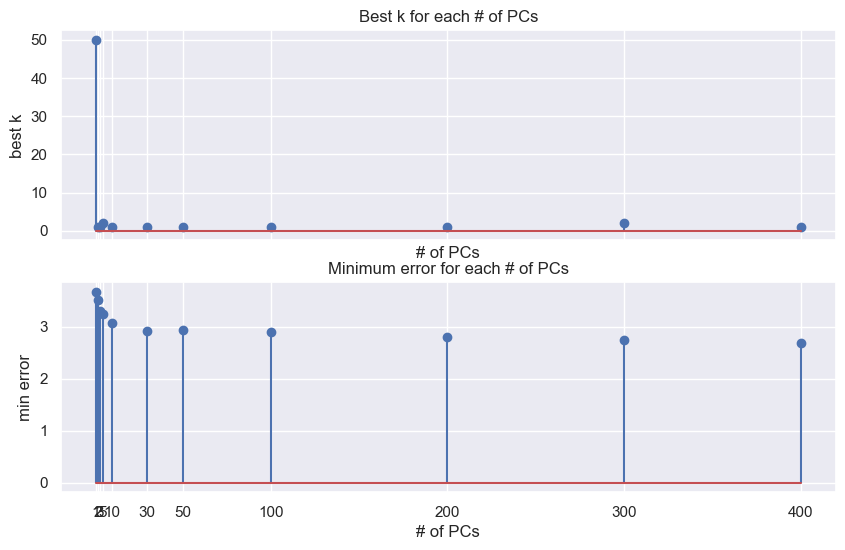

In [34]:
for n_pcs in N_pcs:
	loss(k=427, n_pcs=n_pcs, plot=False, save=True);

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

best_ks = dict(sorted(best_k.items()))
best_ks

axs[0].stem(np.array(list(best_ks.keys())), np.array(list(best_ks.values())) + 1)
axs[0].set_title('Best k for each # of PCs')
axs[0].set_xlabel('# of PCs')
axs[0].set_ylabel('best k')
axs[0].set_xticks(N_pcs)

min_errs = np.empty(len(N_pcs))
for i, n_pcs in enumerate(N_pcs):
    min_errs[i] = losses[n_pcs][best_k[n_pcs]]

axs[1].stem(N_pcs, min_errs)
axs[1].set_title('Minimum error for each # of PCs')
axs[1].set_xlabel('# of PCs')
axs[1].set_ylabel('min error')
axs[1].set_xticks(N_pcs)
plt.show()

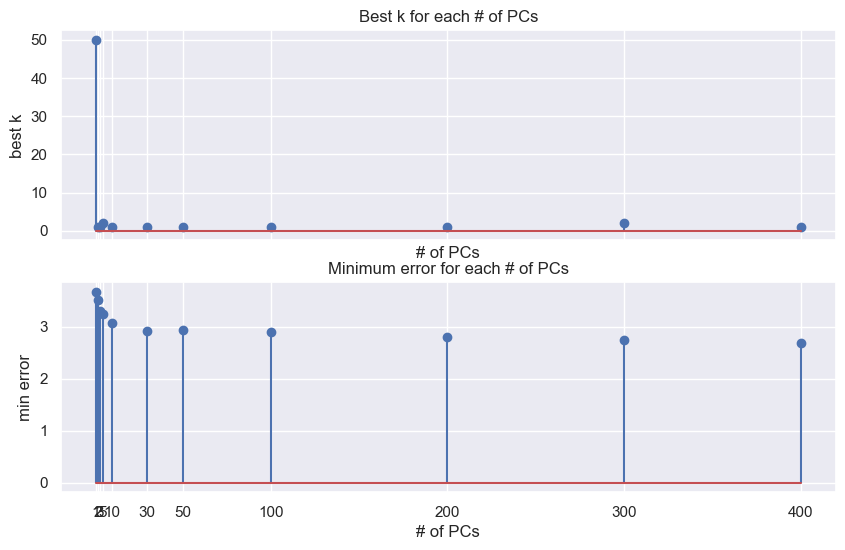

In [35]:
for n_pcs in N_pcs:
	loss(k=427, n_pcs=n_pcs, plot=False, save=True);

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

best_ks = dict(sorted(best_k.items()))
best_ks

axs[0].stem(np.array(list(best_ks.keys())), np.array(list(best_ks.values())) + 1)
axs[0].set_title('Best k for each # of PCs')
axs[0].set_xlabel('# of PCs')
axs[0].set_ylabel('best k')
axs[0].set_xticks(N_pcs)

min_errs = np.empty(len(N_pcs))
for i, n_pcs in enumerate(N_pcs):
    min_errs[i] = losses[n_pcs][best_k[n_pcs]]

axs[1].stem(N_pcs, min_errs)
axs[1].set_title('Minimum error for each # of PCs')
axs[1].set_xlabel('# of PCs')
axs[1].set_ylabel('min error')
axs[1].set_xticks(N_pcs)
plt.show()

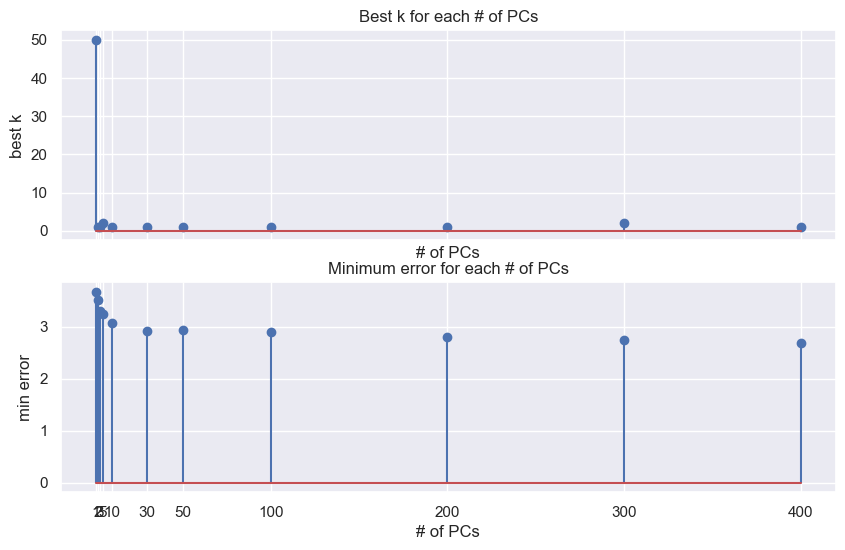

In [36]:
for n_pcs in N_pcs:
	loss(k=427, n_pcs=n_pcs, plot=False, save=True);

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

best_ks = dict(sorted(best_k.items()))
best_ks

axs[0].stem(np.array(list(best_ks.keys())), np.array(list(best_ks.values())) + 1)
axs[0].set_title('Best k for each # of PCs')
axs[0].set_xlabel('# of PCs')
axs[0].set_ylabel('best k')
axs[0].set_xticks(N_pcs)

min_errs = np.empty(len(N_pcs))
for i, n_pcs in enumerate(N_pcs):
    min_errs[i] = losses[n_pcs][best_k[n_pcs]]

axs[1].stem(N_pcs, min_errs)
axs[1].set_title('Minimum error for each # of PCs')
axs[1].set_xlabel('# of PCs')
axs[1].set_ylabel('min error')
axs[1].set_xticks(N_pcs)
plt.show()

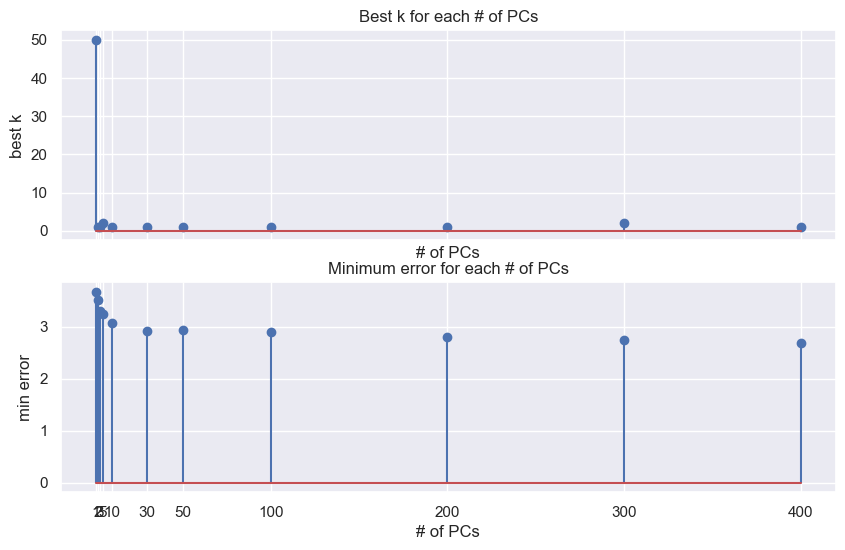

In [37]:
for n_pcs in N_pcs:
	loss(k=427, n_pcs=n_pcs, plot=False, save=True);

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

best_ks = dict(sorted(best_k.items()))
best_ks

axs[0].stem(np.array(list(best_ks.keys())), np.array(list(best_ks.values())) + 1)
axs[0].set_title('Best k for each # of PCs')
axs[0].set_xlabel('# of PCs')
axs[0].set_ylabel('best k')
axs[0].set_xticks(N_pcs)

min_errs = np.empty(len(N_pcs))
for i, n_pcs in enumerate(N_pcs):
    min_errs[i] = losses[n_pcs][best_k[n_pcs]]

axs[1].stem(N_pcs, min_errs)
axs[1].set_title('Minimum error for each # of PCs')
axs[1].set_xlabel('# of PCs')
axs[1].set_ylabel('min error')
axs[1].set_xticks(N_pcs)
plt.show()

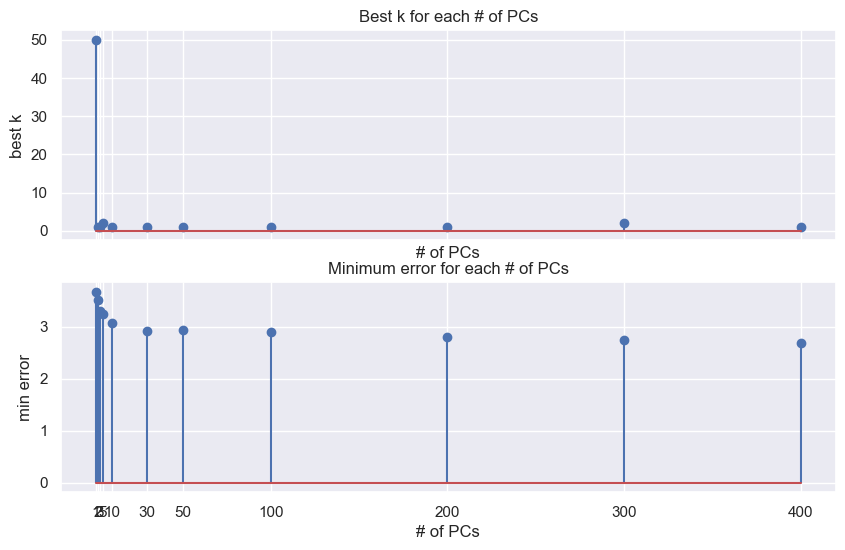

In [38]:
for n_pcs in N_pcs:
	loss(k=427, n_pcs=n_pcs, plot=False, save=True);

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

best_ks = dict(sorted(best_k.items()))
best_ks

axs[0].stem(np.array(list(best_ks.keys())), np.array(list(best_ks.values())) + 1)
axs[0].set_title('Best k for each # of PCs')
axs[0].set_xlabel('# of PCs')
axs[0].set_ylabel('best k')
axs[0].set_xticks(N_pcs)

min_errs = np.empty(len(N_pcs))
for i, n_pcs in enumerate(N_pcs):
    min_errs[i] = losses[n_pcs][best_k[n_pcs]]

axs[1].stem(N_pcs, min_errs)
axs[1].set_title('Minimum error for each # of PCs')
axs[1].set_xlabel('# of PCs')
axs[1].set_ylabel('min error')
axs[1].set_xticks(N_pcs)
plt.show()

So for every increase in the number of PCs, the minimum error does continues to decrease. However, we can choose 30 PCs, since there seems to be diminishing returns beyond that. The best number of neighbors is 1, like we expected from the previous plot, however we can examine the results for the first 5 neighbors like we did in the first example, for the sake of comparison.

In [39]:
def intersect_diff(a, b):
    both_nz = np.nonzero(a*b)
    return np.mean(np.abs(a[both_nz] - b[both_nz]))

# show a comparison of the results between the 2 differtent numbers of components, for user x
def show_results(k=5, n_pcs=(5, 10), x=np.random.randint(0, val.shape[0]), ax=None):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    common = []
    diff = []
    for i in range(2):
        t_proj = train @ pcs[:n_pcs[i]].T
        v_proj = val @ pcs[:n_pcs[i]].T

        dists_p = scipy.spatial.distance.cdist(v_proj, t_proj, metric='cosine')
        idx_p = np.argsort(dists_p, axis=1)

        df = plot_neighbors(x, idx_p[x, :5], ax=axs[i])
        diff.append(np.mean([intersect_diff(val.iloc[x].values, train.iloc[idx_p[x, j]].values) for j in range(k)]))
        common.append(df.iloc[1:, 0].mean())
        axs[i].set_title(axs[i].get_title() + f' ({n_pcs[i]} PCs)')
    plt.show()

    for i in range(2):
        print(f'{n_pcs[i]} PCs:')
        print(f'Average # of common movies rated: {common[i]:.2f}')
        print(f'Average difference in rating for common movies: {diff[i]:.2f}')

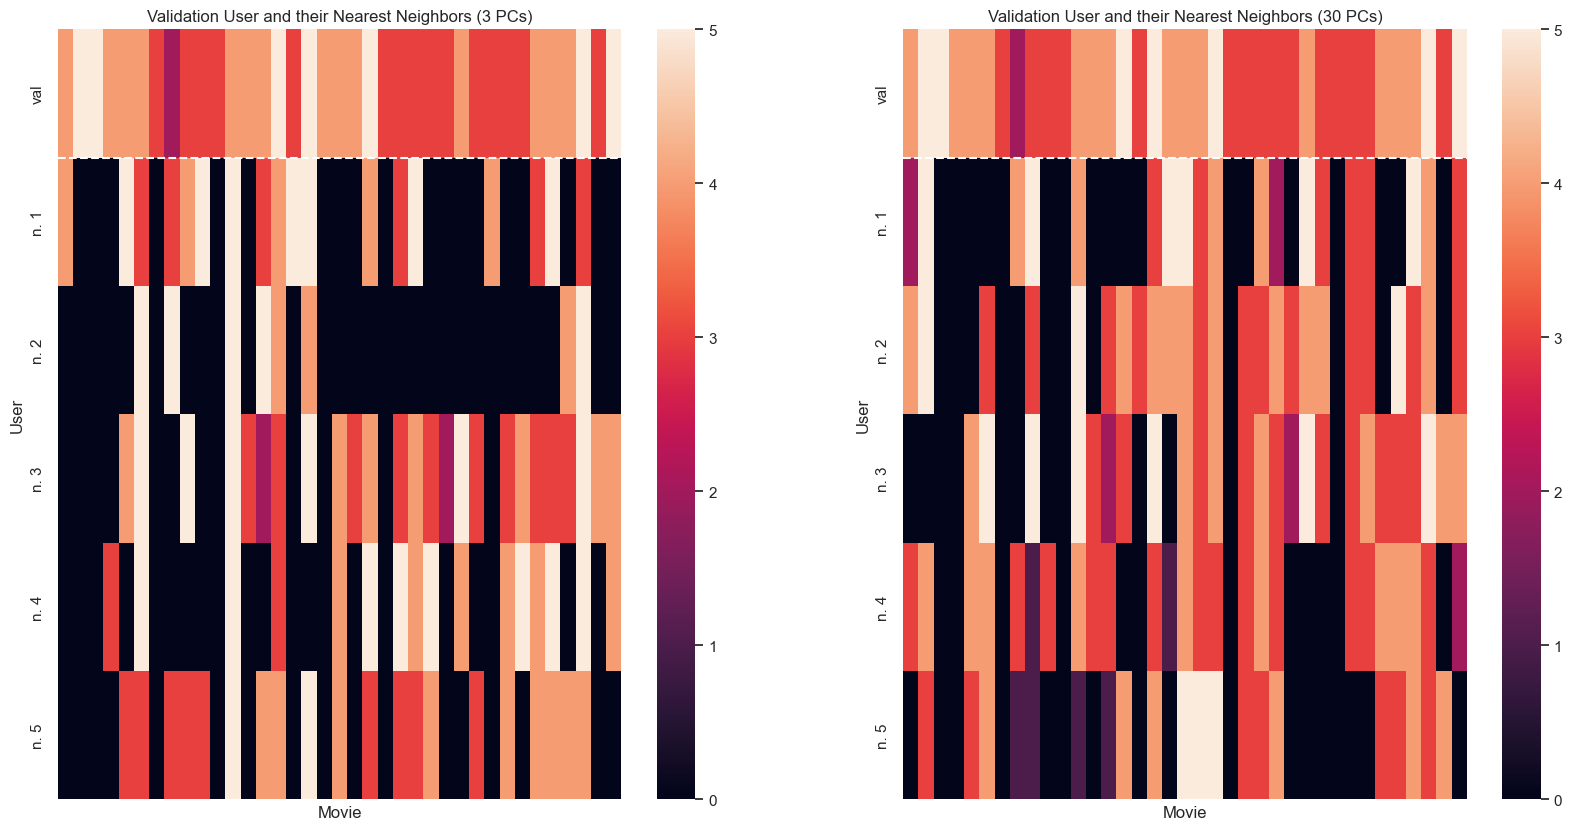

3 PCs:
Average # of common movies rated: 17.40
Average difference in rating for common movies: 0.86
30 PCs:
Average # of common movies rated: 22.80
Average difference in rating for common movies: 0.86


In [40]:
show_results(k=5, n_pcs=(3, 30), x=np.random.randint(0, val.shape[0]))

The visualisations above are pretty and if one was to examine them closely, they would notice that in the case of 30 PCs used (right), in compariston to 3 (left), the average number that the user and their neighbors have rated in common is higher, while at the same time the ratings are closer (because the above is generated for a random user, in some cases it may not be exactly true). However, because it may not be that easy to see from the graph alone, the statistics just below confirm just that.

So, of course, as one would expect, increasing the number of principal components used from 3 to 30, we can find similarity in users more reliably. Like we saw on an earlier plot, if we used even more PCs, then we would be able to find even more similar users, however the difference would not be as big. Another way to improve the model, could be to experiment with different distances and metrics in order to find the optimal ones for each case.